<a href="https://colab.research.google.com/github/pjjongho/Colab_AD/blob/main/Equipment%20crash%20and%20failure%20Anomaly%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Chapter 27]**  
**┗ 장비 충돌 및 고장 이상 탐지**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「데이터 전처리 및 EDA」
* 🥈Session 2 - 「가설 수립 및 검증」
* 🥇Session 3 - 「이상 탐지 모델링」

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/")
os.getcwd()

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 👷

```
A공장에서는 최근 도입한 장비로 인하여 골치를 썩고 있다. 새로 도입한 장비의 지속적인 고장으로 인하여 생산 스케줄을 지연되고  
있기 때문이다. 해당 장비의 특성상 한 번 고장이 나면 라인 전체를 Stop 시켜야 하므로 공정 Process에서 Bottleneck 구간이다.  
고장이 나면 공정상 막대한 손해이기 때문에 고장이 나기 전 사전 이상징후를 포착하고 점검을 통해 고장이 발생하여 미치는
손실을 줄이고자 한다.
```  

> **데이터 살펴보기**

* 장비의 이상징후를 포착하기 위해 장비의 특정 위치의 충돌 센서 4개(S1~S4)를 설치함
* 센서 특정 위치에 충돌이 일어나면 최종적으로 충돌 당시의 M(질량)과 V(속도)가 기록됨
* 장비에 특정 이상의 충격(M*V)이 가해지면 장비는 정지하게 됨
* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|id|센서id|
|Time|측정시간|
|S1|센서값1|
|S2|센서값2|
|S3|센서값3|
|S4|센서값4|






In [ ]:
# ▶ pd.set option
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# ▶ Data read
df_features = pd.read_csv('chapter27_abnormal_features.csv')
df_target = pd.read_csv('chapter27_abnormal_target.csv')

In [ ]:
df_features.head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [ ]:
df_target.head()

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4


* df_features Data set에는 'Time' 시간 별 센서에서 수집되고 있는 S1~S4 값이 수집된다.
* df_target에는 장비에 최종적으로 전달된 M(질량)과 속도(V)가 기록되어 있다.

## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 설비 고장으로 인한 Line stop, 생산 스케줄 지연, 매출감소, 영업이익 감소
```  

> **기대효과**

```
▶ 사전 이상징후 감지 및 점검을 통해 고장으로 인한 Line stop 감소, 생산 스케줄 정상화
```

> **해결방안**

```
▶ 데이터 기반으로 이상징후를 정의하고, 센서 데이터 모니터링을 통해 이상징후 포착 및 실시간 점검
▶ Session 1 🥉
 - 고장이 발생하기 전 이상 증상에 대한 정의  
▶ Session 2 🥈
 - 가설 수립 및 검증
▶ Session 3 🥇
 - 이상 탐지 모델링 수행

```

> **성과측정**  

```
▶ 이상징후 모니터링 전/후 제품 생산량, Line stop 횟수 비교
```

> **현업적용**  

```
▶ 실시간 센서 데이터 수집 및 DB 적재 시스템 구축  
▶ Server에 데이터 모델 탑재 및 특정 시간 단위 실행 및 결과 저장  
▶ 결과 데이터 대시보드 및 BI 시스템에 출력 및 모니터링
```

> **주요 코드 미리 살펴보기**  

```
▶ session 1 → unique(), value_counts()
▶ session 2 → sns.scatterplot(), plt.axhline(), np.where
▶ session 3 → RandomForestClassifier, classification_report, GridSearchCV
```

## **🥉Session 1**  
**┗ 이상(abnormal)정의 및 데이터 EDA**  
---


### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  


In [ ]:
# ▶ Data 형태 확인
# ▶ feature data의 row의 개수와 target data의 row 개수가 다름
print('df_features', df_features.shape)
print('df_target', df_target.shape)

df_features (1050000, 6)
df_target (2800, 5)


In [ ]:
# ▶ Data type 확인
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1050000 non-null  int64  
 1   Time    1050000 non-null  float64
 2   S1      1050000 non-null  float64
 3   S2      1050000 non-null  float64
 4   S3      1050000 non-null  float64
 5   S4      1050000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 48.1 MB


In [ ]:
# ▶ data 정보확인
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2800 non-null   int64  
 1   X       2800 non-null   float64
 2   Y       2800 non-null   float64
 3   M       2800 non-null   float64
 4   V       2800 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 109.5 KB


In [ ]:
# ▶ Null 값 확인
print(df_features.isnull().sum())
print('')
print(df_target.isnull().sum())

id      0
Time    0
S1      0
S2      0
S3      0
S4      0
dtype: int64

id    0
X     0
Y     0
M     0
V     0
dtype: int64


In [ ]:
# ▶ Unique한 ID 개수 확인
# ▶ Unique한 ID 개수가 동일한 것으로 보아, Feature data가 id당 다수의 데이터를 가지고 있는 것으로 추정
print('df_features_unique_id :', len(df_features['id'].unique()))
print('df_target_unique_id :', len(df_target['id'].unique()))

df_features_unique_id : 2800
df_target_unique_id : 2800


In [ ]:
# ▶ 하나의 ID(제품)당 0.000004초의 간격으로 센서 S1~S4에 값이 수집되고 있는 상황
df_features[df_features['id']==0].head(10)

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0
5,0,0.000020,0.0,0.0,0.0,0.0
6,0,0.000024,0.0,0.0,0.0,0.0
7,0,0.000028,0.0,0.0,0.0,0.0
8,0,0.000032,0.0,0.0,0.0,0.0
9,0,0.000036,0.0,0.0,0.0,0.0


In [ ]:
# ▶ Target data set과 차원을 맞춰주기 위해 id 별로 Sensor 값의 평균(mean)을 사용
# ▶ Data를 그룹핑 하는 방법에는 다양한 방법이 있으나, 현업에서 의미있는 방법으로 데이터를 그룹핑 하는 것을 추천
df_features_proc = df_features.groupby('id').mean()

In [ ]:
df_features.groupby('id').mean()

,Time,S1,S2,S3,S4
id,,,,,
0,0.000748,-308.304553,-308.304553,1119.504719,1410.502893
1,0.000748,12780.176893,981.778780,7953.031214,-15584.755221
2,0.000748,-674.289628,-1575.681938,137.430228,-407.092340
3,0.000748,2164.216981,-11274.728589,-4221.738240,5241.350867
4,0.000748,-980.480585,-6966.912566,-2555.746810,5596.931287
...,...,...,...,...,...
2795,0.000748,5600.614397,5885.824925,-6380.192826,-7357.437798
2796,0.000748,-1215.328099,2702.879683,805.983784,-2876.150150
2797,0.000748,436.239993,276.327514,951.805606,-903.193922


In [ ]:
print('df_features', df_features_proc.shape)
print('df_target', df_target.shape)

df_features (2800, 5)
df_target (2800, 5)


In [ ]:
# ▶ Data left join
df_merge = pd.merge(df_features_proc, df_target, on='id',how='left')

In [ ]:
df_merge.head(5)

,id,Time,S1,S2,S3,S4,X,Y,M,V
0,0,0.000748,-308.304553,-308.304553,1119.504719,1410.502893,0.0,-400.0,50.0,0.4
1,1,0.000748,12780.176893,981.778780,7953.031214,-15584.755221,400.0,0.0,100.0,1.0
2,2,0.000748,-674.289628,-1575.681938,137.430228,-407.092340,-300.0,-200.0,25.0,0.4
3,3,0.000748,2164.216981,-11274.728589,-4221.738240,5241.350867,200.0,-100.0,150.0,0.4
4,4,0.000748,-980.480585,-6966.912566,-2555.746810,5596.931287,-300.0,-100.0,150.0,0.4


In [ ]:
# ▶ 전처리 완료된 최종 Data set
df_merge=df_merge.drop(['Time', 'X', 'Y'], axis=1)
df_merge.head(5)

,id,S1,S2,S3,S4,M,V
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4


### · 이상(abnormal) 정의
---
* 장비가 고장나기 전에 사전 점검을 하기 위한 이상(abnormal) 현상을 정의
* 장비가 이상(abnormal)에 도달 시 사전 점검을 하기 위함

In [ ]:
# ▶ 위에서 정의한 것처럼 M(질량) X V(속도) = 최종 충돌 에너지로 정의하고, 새로운 Col을 생성
df_merge['MV'] = df_merge['M'] * df_merge['V']
df_merge.head(5)

,id,S1,S2,S3,S4,M,V,MV
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0


충돌에너지 평균 : 60.0


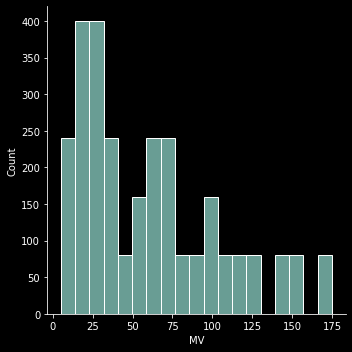

In [ ]:
# ▶ 이상(abnormal)을 정의하기 위해 MV(충돌 에너지)의 분포를 확인
# ▶ 대다수의 충돌에너지 data가 충돌에너지의 평균인 60선에 분포
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.displot(df_merge['MV']);
plt.gcf().set_size_inches(5, 5)
print("충돌에너지 평균 :", df_merge['MV'].mean())

In [ ]:
# ▶ 이상을 정의하는 방법은 다양하고, 보통 현업에 기준이 존재할 확률이 큼
# ▶ 현업의 기준이 존재하지 않는다면, 보통 data의 평균에서 ±1, ±2, ±3 sd(표준편차) 떨어진 Data들을 이상으로 가정하는 경우가 많음
# ▶ mean + 2sd 이상인 충돌 에너지를 이상으로 정의
import numpy as np
df_merge['abnormal'] =  np.where(df_merge['MV'] > (df_merge['MV'].mean() + 2*df_merge['MV'].std()), 1, 0)
df_merge.head(5)

,id,S1,S2,S3,S4,M,V,MV,abnormal
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0


In [ ]:
# ▶ 이상(abnormal) data 분포 확인
df_merge['abnormal'].value_counts()

0    2640
1     160
Name: abnormal, dtype: int64

In [ ]:
# ▶ 약 6%가 이상징후를 보이고 있음
df_merge['abnormal'].value_counts(normalize =True)

0    0.942857
1    0.057143
Name: abnormal, dtype: float64

## **🥈Session 2**  
**┗ 가설 수립 및 검증**  
---


### · 이상(abnormal) 발생 시점 분석
---
* 가설) "이상(abnormal) 시점의 센서 데이터의 분포가 다를 것이다."
* 각 센서(S1~S4)에 대해 이상(1) 상태와 이상이 아닌(0)의 상태를 비교

In [ ]:
# ▶ 이상(abnormal)에 Sensor data 분석
# ▶ 이상(abnormal)과 정상(normal)일 때, 센서 값의 평균 값이 다른 것을 확인
print("S1 abnormal :",df_merge[df_merge['abnormal']==1]['S1'].mean(), "/ normal : ",df_merge[df_merge['abnormal']==0]['S1'].mean())
print("S2 abnormal :",df_merge[df_merge['abnormal']==1]['S2'].mean(), "/ normal : ",df_merge[df_merge['abnormal']==0]['S2'].mean())
print("S3 abnormal :",df_merge[df_merge['abnormal']==1]['S3'].mean(), "/ normal : ",df_merge[df_merge['abnormal']==0]['S3'].mean())
print("S4 abnormal :",df_merge[df_merge['abnormal']==1]['S4'].mean(), "/ normal : ",df_merge[df_merge['abnormal']==0]['S4'].mean())

S1 abnormal : -910.6725618222317 / normal :  -374.457459218389
S2 abnormal : -910.6725618222324 / normal :  -374.45745931738884
S3 abnormal : -3662.427652993808 / normal :  -1193.247454043241
S4 abnormal : -4473.323652485669 / normal :  -1431.8663172477716


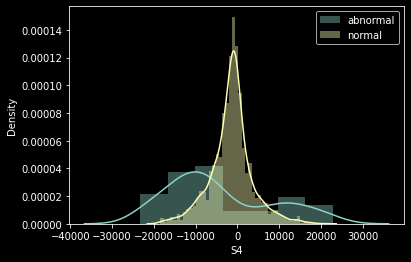

In [ ]:
# ▶ distplot 분포 비교
sns.distplot(df_merge[df_merge['abnormal']==1]['S4'], label='abnormal');
sns.distplot(df_merge[df_merge['abnormal']==0]['S4'], label='normal');
plt.legend();

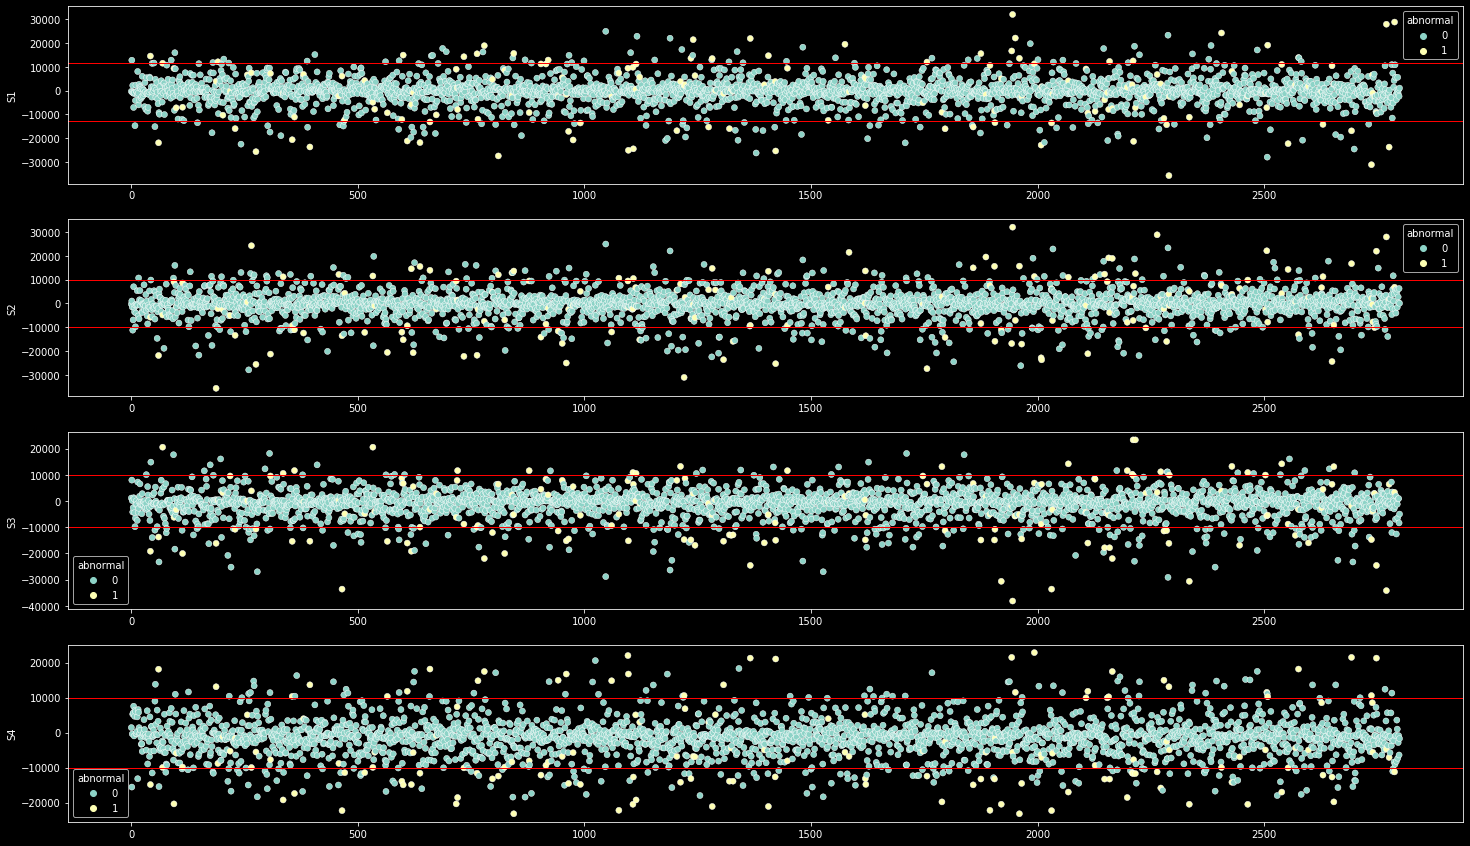

In [ ]:
# ▶ 더 정확한 분포를 확인하기 위해 Scatter plot을 그림
# ▶ 센서값이 중앙(mean)에서 멀어질 수록 이상(abnormal)이 더 많이 발생하고 있는 추세
fig, axes = plt.subplots(4, 1)
sns.scatterplot(x=df_merge.index, y=df_merge['S1'], hue = df_merge['abnormal'], ax=axes[0]);
sns.scatterplot(x=df_merge.index, y=df_merge['S2'], hue = df_merge['abnormal'], ax=axes[1]);
sns.scatterplot(x=df_merge.index, y=df_merge['S3'], hue = df_merge['abnormal'], ax=axes[2]);
sns.scatterplot(x=df_merge.index, y=df_merge['S4'], hue = df_merge['abnormal'], ax=axes[3]);

axes[0].axhline(y=df_merge['S1'].mean()+2*df_merge['S1'].std(), color='r', linewidth=1)
axes[0].axhline(y=df_merge['S1'].mean()-2*df_merge['S1'].std(), color='r', linewidth=1)

axes[1].axhline(y=10000, color='r', linewidth=1)
axes[1].axhline(y=-10000, color='r', linewidth=1)

axes[2].axhline(y=10000, color='r', linewidth=1)
axes[2].axhline(y=-10000, color='r', linewidth=1)

axes[3].axhline(y=10000, color='r', linewidth=1)
axes[3].axhline(y=-10000, color='r', linewidth=1)
plt.gcf().set_size_inches(25, 15)

### · Rule base 이상진단
---
* Scatter plot을 통해 각 센서 값이 10,000 초과 -10,000 미만 일시 더 많은 불량이 발생하는 인사이트를 확인
* 실제 평균 이상률(6%) 대비 더 많은 불량이 발생하는지 수치로 확인

In [ ]:
# ▶ S1 불량률 확인
df_s1 = df_merge[(df_merge['S1'] > 10000) | (df_merge['S1'] < -10000)]
df_s1_abnormal_ratio = (len(df_s1[df_s1['abnormal']==1]) / len(df_s1)) * 100
print(f'{round(df_s1_abnormal_ratio,1)}%')
print(len(df_s1), len(df_s1[df_s1['abnormal']==1]))

27.0%
278 75


In [ ]:
# ▶ S1_normal 불량률 확인 (3%)
df_s1_normal = df_merge[(df_merge['S1'] < 10000) & (df_merge['S1'] > -10000)]
print(df_s1_normal['abnormal'].value_counts(normalize=True))
print(df_s1_normal['abnormal'].value_counts())

0    0.966297
1    0.033703
Name: abnormal, dtype: float64
0    2437
1      85
Name: abnormal, dtype: int64


In [ ]:
# ▶ S2 불량률 확인
df_s2 = df_merge[(df_merge['S2'] > 10000) | (df_merge['S2'] < -10000)]
df_s2_abnormal_ratio = (len(df_s2[df_s2['abnormal']==1]) / len(df_s2)) * 100
print(f'{round(df_s2_abnormal_ratio,1)}%')
print(len(df_s2), len(df_s2[df_s2['abnormal']==1]))

27.0%
278 75


In [ ]:
# ▶ S2_normal 불량률 확인 (3%)
df_s2_normal = df_merge[(df_merge['S2'] < 10000) & (df_merge['S2'] > -10000)]
print(df_s2_normal['abnormal'].value_counts(normalize=True))
print(df_s2_normal['abnormal'].value_counts())

0    0.966297
1    0.033703
Name: abnormal, dtype: float64
0    2437
1      85
Name: abnormal, dtype: int64


In [ ]:
# ▶ S3 불량률 확인
df_s3 = df_merge[(df_merge['S3'] > 10000) | (df_merge['S3'] < -10000)]
df_s3_abnormal_ratio = (len(df_s3[df_s3['abnormal']==1]) / len(df_s3)) * 100
print(f'{round(df_s3_abnormal_ratio,1)}%')
print(len(df_s3), len(df_s3[df_s3['abnormal']==1]))

28.6%
255 73


In [ ]:
# ▶ S3_normal 불량률 확인 (3%)
df_s3_normal = df_merge[(df_merge['S3'] < 10000) & (df_merge['S3'] > -10000)]
print(df_s3_normal['abnormal'].value_counts(normalize=True))
print(df_s3_normal['abnormal'].value_counts())

0    0.965815
1    0.034185
Name: abnormal, dtype: float64
0    2458
1      87
Name: abnormal, dtype: int64


In [ ]:
# ▶ S4 불량률 확인
df_s4 = df_merge[(df_merge['S4'] > 10000) | (df_merge['S4'] < -10000)]
df_s4_abnormal_ratio = (len(df_s4[df_s4['abnormal']==1]) / len(df_s4)) * 100
print(f'{round(df_s4_abnormal_ratio,1)}%')
print(len(df_s4), len(df_s4[df_s4['abnormal']==1]))

31.3%
300 94


In [ ]:
# ▶ s4_normal 불량률 확인 (3%)
df_s4_normal = df_merge[(df_merge['S4'] < 10000) & (df_merge['S4'] > -10000)]
print(df_s4_normal['abnormal'].value_counts(normalize=True))
print(df_s4_normal['abnormal'].value_counts())

0    0.9736
1    0.0264
Name: abnormal, dtype: float64
0    2434
1      66
Name: abnormal, dtype: int64


In [ ]:
# ▶ 상위의 인사이트를 활용하여 이상을 예측
# ▶ S1, S2, S3, S4가 10,000 초과, -10,000 미만 일시 이상으로 예측
df_merge['rule_base1'] = np.where( ((df_merge['S1'] > 10000) | (df_merge['S1'] < -10000)) , 1, 0)
df_merge['rule_base2'] = np.where( ((df_merge['S2'] > 10000) | (df_merge['S2'] < -10000)) , 1, 0)
df_merge['rule_base3'] = np.where( ((df_merge['S3'] > 10000) | (df_merge['S3'] < -10000)) , 1, 0)
df_merge['rule_base4'] = np.where( ((df_merge['S4'] > 10000) | (df_merge['S4'] < -10000)) , 1, 0)

In [ ]:
df_merge.head(5)

,id,S1,S2,S3,S4,M,V,MV,abnormal,rule_base1,rule_base2,rule_base3,rule_base4
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0,0,0,0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0,1,0,0,1
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0,0,0,0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0,0,1,0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0,0,0,0,0


In [ ]:
# ▶ presision : 예측한 것 중에 실제로 정답인 비율
# ▶ recall : 실제 정답중에서 예측으로 맞춘 비율
# ▶ S4 센서를 기준으로 이상을 예측 했을 때가 Best Score(recall 0.59)
from sklearn.metrics import classification_report
print(classification_report(df_merge['abnormal'], df_merge['rule_base1']))
print('--------------------------------------------------------')
print(classification_report(df_merge['abnormal'], df_merge['rule_base2']))
print('--------------------------------------------------------')
print(classification_report(df_merge['abnormal'], df_merge['rule_base3']))
print('--------------------------------------------------------')
print(classification_report(df_merge['abnormal'], df_merge['rule_base4']))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2640
           1       0.27      0.47      0.34       160

    accuracy                           0.90      2800
   macro avg       0.62      0.70      0.64      2800
weighted avg       0.93      0.90      0.91      2800

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2640
           1       0.27      0.47      0.34       160

    accuracy                           0.90      2800
   macro avg       0.62      0.70      0.64      2800
weighted avg       0.93      0.90      0.91      2800

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2640
           1       0.29      0.46      0.35       160

    accuracy                           0.90      2800
   macro avg  

## **🥇Session 3**  
**┗ ML 활용 이상진단 및 예측**  
---

### · Model Selection
---
* 1) Supervised-learning (RFC)
* 2) Unsupervised-learning (Isoaltion Forest)


### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
df_merge.head(5)

,id,S1,S2,S3,S4,M,V,MV,abnormal,rule_base1,rule_base2,rule_base3,rule_base4
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0,0,0,0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0,1,0,0,1
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0,0,0,0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0,0,1,0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0,0,0,0,0


In [ ]:
# ▶ 모델링을 학습하기 위한 Fearue(X)와 Y데이터를 구분하는 단계
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df_merge.drop(['id', 'M', 'V', 'MV', 'rule_base1', 'rule_base2', 'rule_base3', 'rule_base4', 'abnormal'], axis=1)
Y=df_merge['abnormal']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state = 123456)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1960, 4)
(1960,)
(840, 4)
(840,)


### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [ ]:
# ▶ 모델 학습
rfc = RandomForestClassifier(random_state=123456)
rfc.fit(x_train, y_train)

# ▶ 예측
# ▶ 예측은 학습에 사용된 Data와 Test Data 모두 예측하고 평가함(※ 과적합 여부 판별)
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       1.00      1.00      1.00       112

    accuracy                           1.00      1960
   macro avg       1.00      1.00      1.00      1960
weighted avg       1.00      1.00      1.00      1960

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       792
           1       0.75      0.62      0.68        48

    accuracy                           0.97       840
   macro avg       0.86      0.81      0.83       840
weighted avg       0.96      0.97      0.97       840



In [ ]:
pd.Series(y_train).value_counts()

0    1848
1     112
Name: abnormal, dtype: int64

In [ ]:
pd.Series(y_pred_train).value_counts()

0    1848
1     112
dtype: int64

### · Hyper paramter 튜닝
---
* 모델 성능을 올리기 위한 옵션 조절

In [ ]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [400, 500],
           'max_depth' : [6, 8, 10, 12]
            }

# ▶ RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 123456, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1, scoring='recall')
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도(recall): {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'n_estimators': 400}
최고 예측 정확도(recall): 0.4011


In [ ]:
# ▶ Best score 파라미터로 다시 재학습
rfc = RandomForestClassifier(n_estimators=400, max_depth=8, random_state = 123456)
rfc.fit(x_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1848
           1       1.00      0.66      0.80       112

    accuracy                           0.98      1960
   macro avg       0.99      0.83      0.89      1960
weighted avg       0.98      0.98      0.98      1960

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       792
           1       0.73      0.46      0.56        48

    accuracy                           0.96       840
   macro avg       0.85      0.72      0.77       840
weighted avg       0.95      0.96      0.96       840



In [ ]:
pd.Series(y_pred_train).value_counts()

0    1886
1      74
dtype: int64

### · 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

In [ ]:
x_train.columns

Index(['S1', 'S2', 'S3', 'S4'], dtype='object')

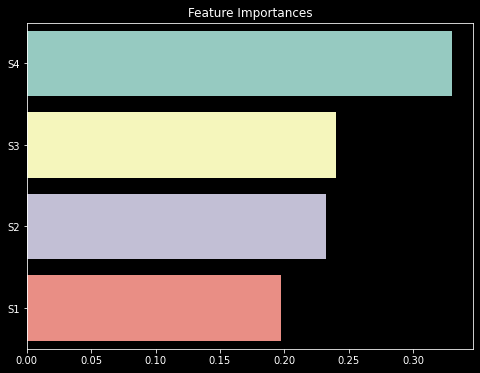

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

### · 변수 추가
---
* 모델의 성능을 향상시키기 위한 추가 변수 탐색

In [ ]:
df_new=df_merge.copy()

# ▶ 제곱
df_new['S1_2']=df_new['S1']*df_new['S1']
df_new['S2_2']=df_new['S2']*df_new['S2']
df_new['S3_2']=df_new['S3']*df_new['S3']
df_new['S4_2']=df_new['S4']*df_new['S4']

# ▶ 곱셈
df_new['s1*s2']=df_new['S1']*df_new['S2']
df_new['s2*s3']=df_new['S2']*df_new['S3']
df_new['s3*s4']=df_new['S3']*df_new['S4']
df_new['s1*s4']=df_new['S3']*df_new['S4']

df_new.head(5)

,id,S1,S2,S3,S4,M,V,MV,abnormal,rule_base1,rule_base2,rule_base3,rule_base4,S1_2,S2_2,S3_2,S4_2,s1*s2,s2*s3,s3*s4,s1*s4
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0,0,0,0,0,9.505170e+04,9.505170e+04,1.253291e+06,1.989518e+06,9.505170e+04,-3.451484e+05,1.579065e+06,1.579065e+06
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0,1,0,0,1,1.633329e+08,9.638896e+05,6.325071e+07,2.428846e+08,1.254731e+07,7.808117e+06,-1.239460e+08,-1.239460e+08
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0,0,0,0,0,4.546665e+05,2.482774e+06,1.888707e+04,1.657242e+05,1.062466e+06,-2.165463e+05,-5.594679e+04,-5.594679e+04
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0,0,1,0,0,4.683835e+06,1.271195e+08,1.782307e+07,2.747176e+07,-2.440096e+07,4.759895e+07,-2.212761e+07,-2.212761e+07
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0,0,0,0,0,9.613422e+05,4.853787e+07,6.531842e+06,3.132564e+07,6.830923e+06,1.780566e+07,-1.430434e+07,-1.430434e+07


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df_new.drop(['id', 'M', 'V', 'MV', 'rule_base1', 'rule_base2', 'rule_base3', 'rule_base4', 'abnormal'], axis=1)
Y=df_new['abnormal']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state = 123456)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1960, 12)
(1960,)
(840, 12)
(840,)


In [ ]:
# ▶ 학습
rfc = RandomForestClassifier(n_estimators=400, max_depth=8, random_state=123456)
rfc.fit(x_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1848
           1       1.00      0.71      0.83       112

    accuracy                           0.98      1960
   macro avg       0.99      0.85      0.91      1960
weighted avg       0.98      0.98      0.98      1960

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       792
           1       0.88      0.44      0.58        48

    accuracy                           0.96       840
   macro avg       0.92      0.72      0.78       840
weighted avg       0.96      0.96      0.96       840



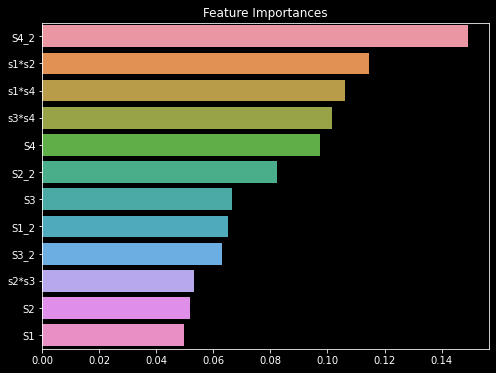

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### · Isoaltion Forest 비교분석
---

In [ ]:
from sklearn.ensemble import IsolationForest

# ▶ 학습
clf = IsolationForest(max_samples=100, contamination = 0.06, random_state=123456)
clf.fit(x_train)

# ▶ 예측
y_pred_test = clf.predict(x_test)

In [ ]:
y_pred_test = np.where(y_pred_test==-1, 1, 0)
y_pred_test[0:5]

array([0, 0, 0, 0, 0])

In [ ]:
# ▶ Unsupervised learning임에도 불구하고, 성능이 크게 낮지 않음
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       792
           1       0.51      0.54      0.53        48

    accuracy                           0.94       840
   macro avg       0.74      0.76      0.75       840
weighted avg       0.95      0.94      0.94       840



In [ ]:
pd.Series(y_pred_test).value_counts()

0    789
1     51
dtype: int64